In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
# tf.enable_eager_execution()
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_probability
tfd = tensorflow_probability.distributions

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '../data/z00/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200]
rprob = 0.5


In [3]:
suff = '-pad2'
num_cubes= 500
cube_size = 32
pad = 2
cube_sizeft = cube_size + 2*pad
max_offset = ncp - cube_size
ftname = ['cic']
nchannels = len(ftname)

In [4]:
# gm = tfd.MixtureSameFamily(
#   mixture_distribution=tfd.Categorical(
#       probs=[0.3, 0.7]),
#   components_distribution=tfd.Normal(
#     loc=[-1., 1],       # One for each component.
#     scale=[0.1, 0.5]))  # And same here.

# # with tf.Session():
# #     print(gm.mean().eval())
# gm.mean().numpy()

# xx = np.linspace(-2., 3., int(1e4), dtype=np.float32)
# plt.plot(xx, gm.prob(xx).numpy());

# pm = tfd.MixtureSameFamily(
#   mixture_distribution=tfd.Categorical(
#       probs=[0.3, 0.7]),
#   components_distribution=tfd.Poisson(rate = [1., 7.]))


# # with tf.Session():
# #     print(gm.mean().eval())
# pm.mean().numpy()

# # xx = np.linspace(-2., 10., int(1e4), dtype=np.float32)
# xx = np.arange(-1., 20., 1).astype(float32)
# plt.plot(xx, pm.prob(xx).numpy(), 'o')
# plt.show()
# plt.plot(xx, tfd.Poisson(5.).prob(xx).numpy(), 'o')


# Training data set

In [5]:
#############################
##Read data and generate meshes
#mesh = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/d/')
meshes = {}
cube_features, cube_target = [], []

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    #mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    #mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    #hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]    
    #hposd = hposall[:num].copy()
    #massd = massall[:num].copy()
    #hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    #hmesh['mnn'] = tools.paintnn(hposd, bs, ncp, massd)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)
    
    features, target = dtools.randomvoxels(ftlistpad, targetmesh, num_cubes, max_offset, cube_size, cube_sizeft,
                                           seed=seed, rprob=rprob)
    cube_features = cube_features + features
    cube_target = cube_target + target

#
cube_target = np.stack(cube_target,axis=0).reshape((-1,cube_size,cube_size,cube_size, ntarget))
cube_features = np.stack(cube_features,axis=0).reshape((-1,cube_sizeft,cube_sizeft,cube_sizeft,nchannels))
print(cube_target[0].shape)
print(cube_features[0].shape)
trainingsize = cube_features.shape[0]
print('Training size is = ', trainingsize)


All the mesh have been generated for seed = 100
Length of targets =  2
Supplemented by rotation :  248
All the mesh have been generated for seed = 200
Length of targets =  2
Supplemented by rotation :  231
(32, 32, 32, 2)
(36, 36, 36, 1)
Training size is =  1479


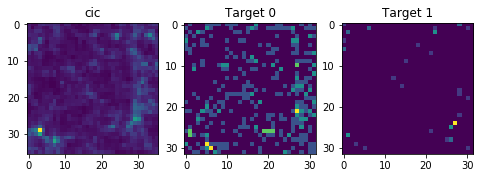

In [6]:
fig, ax = plt.subplots(1, nchannels+ntarget, figsize = (nchannels*4+4, 5))
n = 10
for i in range(nchannels):
    ax[i].imshow(cube_features[n][:,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
for j in range(ntarget):
    ax[i+j+1].imshow(cube_target[n][:,:,:,j].sum(axis=0))
    ax[i+j+1].set_title('Target %d'%j)
# ax[-1].imshow(cube_target[n][:,:,:,0].sum(axis=0))
# ax[-1].set_title('Target')

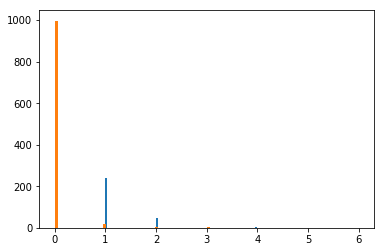

In [7]:
hist(cube_target[n][:,:,:,0].sum(axis=0).flatten(),100);
hist(cube_target[n][:,:,:,1].sum(axis=0).flatten(),100);

In [8]:
tmp = cube_target[0][:, :, :, 1]
np.unique(tmp, return_counts=True)

(array([0., 1., 2., 3.]), array([32739,    23,     5,     1]))

In [9]:
# pm = tfd.MixtureSameFamily(
#   mixture_distribution=tfd.Categorical(
#       probs=[0.2, 0.2, 0.2, 0.2, 0.2]),
#   components_distribution=tfd.Poisson(rate = [0.1, 1., 2., 3., 4.]))


# np.unique(pm.log_prob(tmp.astype(float32)), return_counts=True)

# Model

In [10]:
mmask = cube_target[:, :, :, :, 0].astype(bool)
np.unique(cube_target[mmask][:, 0], return_counts=True), np.unique(cube_target[mmask][:, 1], return_counts=True)

((array([1., 2., 3.]), array([560878,  13260,    282])),
 (array([0., 1., 2., 3., 4., 5., 6., 7., 9.]),
  array([534196,  30903,   6478,   1819,    603,    241,    101,     54,
             25])))

In [94]:
# Define the network
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
ycen = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='centrals')
ysat = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='satellites')
ywt = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size], name='weights')
# x = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
# y = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
# m = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size], name='mask')

lr = tf.placeholder(tf.float32, name='learningrate')

net = slim.conv3d(x, 16, 5, activation_fn=tf.nn.leaky_relu, padding='valid')
# net = slim.conv3d(net, 32, 5, activation_fn=None, padding='valid')
net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
# net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
net = slim.conv3d(net, 16, 1, activation_fn=tf.nn.relu6) #relu6. relu leads to high rates. Sigmoid to bad mask


# Create mixture components from network output
#Trying different initializers here
# out_rate = slim.conv3d(net, 1, 1, activation_fn=tf.nn.relu, 
# #                        weights_initializer=tf.initializers.random_uniform(minval=0.1, maxval=1))
#                        weights_initializer=tf.initializers.random_normal(mean=0.5, stddev=0.2))
out_rate = slim.conv3d(net, 1, 1, activation_fn=tf.nn.relu)
out_rate = tf.math.add(out_rate, 1e-6, name='rate')


# Predicted mask
out_mask = slim.conv3d(net, 1, 1, activation_fn=None)
pred_mask = tf.nn.sigmoid(out_mask, name='prediction')

pdf = tfd.Poisson(rate=out_rate)

# loss = - tf.reduce_mean(pdf.log_prob(y) * m) + \
#     tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=out_mask,labels=tf.expand_dims(m,-1)))
loss0 = - tf.reduce_mean(pdf.log_prob(ysat) * ywt, name='loss0') 
loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=out_mask,labels=ycen), name='loss1') 
loss = tf.math.add(loss0, loss1)

optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='optimizer')

opt_op = optimizer.minimize(loss, name='minimize')

# Train

In [95]:
##Setup

cube_centrals = cube_target[:, :, :, :, 0:1].copy()
cube_centrals[cube_centrals > 1] = 1

cube_satellites = cube_target[:, :, :, :, 1:].copy()

mmask = cube_target[:, :, :, :, 0].astype(bool)
np.unique(cube_target[mmask][:, 0], return_counts=True), 
nsat = np.unique(cube_target[mmask][:, 1], return_counts=True)

#Try different weightings for satellites.
wts = cube_target[:, :, :, :, 1].copy()
for i, ns in enumerate(nsat[0]):
    wts[wts == ns] = 1/nsat[1][i]**0.5
#     wts[wts == ns] = 1
    
wts *= mmask
print(np.unique(wts, return_counts=True))

(1479, 32, 32, 32)


In [96]:
wts.sum(), cube_centrals.sum()

(1092.2939612136486, 574420.0)

In [97]:
np.unique(cube_target[:, :, :, :, 0]), np.unique(cube_centrals[:, :, :, :, 0])

(array([0., 1., 2., 3.]), array([0., 1.]))

In [98]:
sess = tf.Session()
# sess.reset(sess)
sess.run(tf.global_variables_initializer())
losses = []

niter= 3000
nprint = 100
batch_size=32


In [ ]:
#

start = time()
curr = time()
lr0, nlr = 0.001, int(2000)
lacc = 0 
for it in range(niter):
    inds = np.random.choice(int(trainingsize), batch_size, replace=False)
#     _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, x:cube_features[inds], y:cube_satellites[inds],
#                                                m:1.*(squeeze(cube_centrals[inds])>0) })
    _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, x:cube_features[inds], ysat:cube_satellites[inds],
                                               ywt:wts[inds], ycen:cube_centrals[inds] })
    lacc += l
    if it % nlr == nlr-1:
        lr0 /= 10
        print('reduce learning rate by half. New learning rate = %0.2e'%lr0)        
    if it % nprint == 0:
        print('Iteration %d of %d'%(it, niter), '\nLoss = ', lacc/nprint)
        end = time()
        print('Time taken for last batch = %0.3f, Total time elapsed = %0.3f'%(end-curr, end - start))
        lacc=0
        curr = end
    losses.append(l)

Iteration 0 of 3000 
Loss =  0.010389361381530762
Time taken for last batch = 0.627, Total time elapsed = 0.627
Iteration 100 of 3000 
Loss =  0.040861631110310555
Time taken for last batch = 26.923, Total time elapsed = 27.551
Iteration 200 of 3000 
Loss =  0.02736209562048316
Time taken for last batch = 26.902, Total time elapsed = 54.452
Iteration 300 of 3000 
Loss =  0.026101063825190066
Time taken for last batch = 26.869, Total time elapsed = 81.321
Iteration 400 of 3000 
Loss =  0.025558534301817416
Time taken for last batch = 26.847, Total time elapsed = 108.168
Iteration 500 of 3000 
Loss =  0.02502354556694627
Time taken for last batch = 26.869, Total time elapsed = 135.037
Iteration 600 of 3000 
Loss =  0.024591118171811102
Time taken for last batch = 26.816, Total time elapsed = 161.853
Iteration 700 of 3000 
Loss =  0.024063247665762903
Time taken for last batch = 26.864, Total time elapsed = 188.717
Iteration 800 of 3000 
Loss =  0.023566984627395867
Time taken for last ba

In [ ]:
# #
# start = time()
# curr = time()
# lr0, nlr = 0.00001, int(2000)
# lacc = 0 
# for it in range(niter):
#     inds = np.random.choice(int(trainingsize), batch_size, replace=False)
#     _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, x:cube_features[inds], y:cube_target[inds], m:1.*(squeeze(cube_target[inds])>0) })
#     lacc += l
#     if it % nlr == nlr-1:
#         lr0 /= 10
#         print('reduce learning rate by half. New learning rate = %0.2e'%lr0)        
#     if it % nprint == 0:
#         print('Iteration %d of %d'%(it, niter), '\nLoss = ', lacc/nprint)
#         end = time()
#         print('Time taken for last batch = %0.3f, Total time elapsed = %0.3f'%(end-curr, end - start))
#         lacc=0
#         curr = end
#     losses.append(l)

### Diagnostics

In [ ]:
plot(losses)
yscale('log')


In [ ]:
inds = np.random.choice(int(trainingsize), batch_size, replace=False)
input = cube_features[inds]
ploss0, ploss1 = sess.run([loss0, loss1], feed_dict={x:input, ysat:cube_satellites[inds],
                                               ywt:wts[inds], ycen:cube_centrals[inds] })

print('Loss sat, loss cen :', ploss0, ploss1)

# ind = 10
# recp, recm, rates = sess.run([pdf.sample(), pred_mask, out_rate], feed_dict={x:input.reshape(1, *input.shape)})
recp, recm, rates = sess.run([pdf.sample(), pred_mask, out_rate], feed_dict={x:input})

ind = 10 
fig, axar = plt.subplots(2, 2, figsize=(10,10))
ax = axar[0]
ax[0].imshow(recm[ind, 0,:,:,0] );
ax[0].set_title('predict mask')
im = ax[1].imshow(recp[ind,0,:,:,0] );
plt.colorbar(im, ax=ax[1])
ax[1].set_title('predict sats')
ax = axar[1]
ax[0].imshow(cube_target[inds][ind,0,:,:,0]);
ax[0].set_title('target cen')
im = ax[1].imshow(cube_target[inds][ind,0,:,:,1]);
plt.colorbar(im, ax=ax[1])
ax[1].set_title('target sat')
plt.show()

#Rates
plt.hist(rates.flatten(), log=True, histtype='step')
plt.hist(cube_satellites[ind].flatten(), log=True)
plt.show()

# Prediction

In [ ]:
input = x
#############################
samplesat = pdf.sample()

# meshes = {}
tseeds = [100,  500]

for seed in tseeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    #mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    #mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)
    hmesh['mnnsat'] = tools.paintnn(hposd[galtype], bs, ncp, massd[galtype])
    hmesh['mnncen'] = tools.paintnn(hposd[~galtype], bs, ncp, massd[~galtype])

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube)
    satmesh,cenmesh, rates = sess.run([samplesat, pred_mask, out_rate], feed_dict={input:inp})
    mesh['predictsat'] = dtools.uncubify(satmesh[:,:,:,:,0], [nc,nc,nc])
    mesh['predictcen'] = dtools.uncubify(cenmesh[:,:,:,:,0], [nc,nc,nc])
    mesh['predict'] = mesh['predictcen'] + mesh['predictsat']
    mesh['rates'] =  dtools.uncubify(rates[:,:,:,:,0], [nc,nc,nc])
    meshes[seed] = [mesh, hmesh]
 

In [ ]:

##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5


fig, ax = plt.subplots(2, 3, figsize = (12, 8))
for seed in tseeds:
    for i, key in enumerate(['', 'cen', 'sat']):
        predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
        k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
        k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
        k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
    ##
        ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
        ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
        ax[0, i].set_title(key, fontsize=12)
    predict, hpmeshd = meshes[seed][0]['rates'] , meshes[seed][1]['pnnsat'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
    ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Transfer function', fontsize=14)
ax[1, 0].set_ylabel('Cross correlation', fontsize=14)
#plt.savefig('./figs/n%02d/2ptpredict%s.png'%(numd*1e4, suff))
# ax[1].set_ylim(0.2,1.1)
plt.show()

# ##################################################
fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, key in enumerate(['', 'cen', 'sat']):
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
    im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
#     plt.colorbar(im, ax=ax[0, i])
    im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
#     plt.colorbar(im, ax=ax[1, i])
    ax[0, i].set_title(key, fontsize=15)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Prediction', fontsize=15)
ax[1, 0].set_ylabel('Truth', fontsize=15)
plt.show()


In [ ]:
im = plt.imshow(meshes[100][0]['rates'].sum(axis=0))
plt.colorbar(im)

In [ ]:
im = plt.imshow(meshes[100][1]['pnnsat'].sum(axis=0))
plt.colorbar(im)

In [ ]:
cenmask = (meshes[100][1]['mnncen'] > 0)
satmask = (meshes[100][1]['mnnsat'] > 0)
meshes[100][1]['mnncen'][cenmask]

In [ ]:
plt.hist(np.random.poisson(3.25, 10000), normed=True)

In [ ]:
plt.plot(meshes[100][1]['pnnsat'][satmask], meshes[100][0]['rates'][satmask], '.')

In [ ]:
plt.hist(meshes[100][0]['rates'][satmask], log=True)
plt.hist(meshes[100][0]['rates'].flatten(), log=True, histtype='step')
plt.show()

In [93]:
satmesh.sum(), meshes[100][1]['pnnsat'].sum()

(7994.0, 3012.0)